![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import datetime
import time
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/world-cities/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
def IQR(x):
    '''Функция для расчета межквартильного размаха'''
    return x.quantile(0.75) - x.quantile(0.25)


def perc25(x):
    '''Функция для расчета нижнего квартиля'''
    return x.quantile(0.25)


def perc75(x):
    '''Функция для расчета верхнего квартиля'''
    return x.quantile(0.75)


def outlier_low(x):
    '''Функция для расчета границы нижнего выброса'''
    return perc25(x) - 1.5*IQR(x)


def outlier_high(x):
    '''Функция для расчета границы верхнего выброса'''
    return perc75(x) + 1.5*IQR(x)

def outlier_diag(x):
    '''
    Функция показывает границы выбросов вычисленные по формулам и гистограму выбросов
    '''
    print(' 25-й перцентиль: {},\n'.format(perc25(x)),
          '75-й перцентиль: {},\n'.format(perc75(x)),
          "IQR: {}, ".format(IQR(x)),
          "Границы выбросов: [{f}, {l}],\n".format(f=outlier_low(x),
                                                 l=outlier_high(x)),
          'Количество выбросов снизу:{},\n'.format(len(data.loc[x<=outlier_low(x)])),
          'Процент выбросов снизу:{}%,\n'.format(len(data.loc[x<=outlier_low(x)])/len(data)*100),
          'Количество выбросов сверху:{},\n'.format(len(data.loc[x>=outlier_high(x)])),
          'Процент выбросов сверху:{}%.'.format(len(data.loc[x>=outlier_high(x)])/len(data)*100))
    
def sns_distplot_boxplot(x):
    '''
    Функция формирует диаграмму распределения данных и диаграмму boxplot выбросов
    '''
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data[x], bins=50)
    plt.title(f'{x} distribution\n', fontsize=15)
    plt.xlabel(f'{x}')
    plt.ylabel('quantity (frequency)')
    plt.subplot(122)
    sns.boxplot(data[x])
    plt.title(f'{x} distribution\n', fontsize=15)
    plt.xlabel(f'{x}')

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
43813,id_8281,Paris,NaN,8282.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d13149443-Reviews-L...,d13149443,1,5.0
17339,id_1799,Paris,['French'],1800.0,$$ - $$$,210.0,"[['Neighborhood Restaurant', 'Classic French B...",/Restaurant_Review-g187147-d782539-Reviews-Le_...,d782539,1,4.0
39459,id_685,London,"['Italian', 'Cafe', 'Mediterranean', 'European...",686.0,$,167.0,"[['Great service, reasonable prices', 'Fabulou...",/Restaurant_Review-g186338-d2303819-Reviews-Si...,d2303819,1,4.5
29938,id_814,Lyon,NaN,815.0,NaN,19.0,"[['Just perfect !', 'Beautiful familiar'], ['0...",/Restaurant_Review-g187265-d7844725-Reviews-LA...,d7844725,1,4.5
49155,id_2802,Amsterdam,['Mexican'],2809.0,$$ - $$$,7.0,"[['So disappointed.', 'Perfect'], ['11/03/2017...",/Restaurant_Review-g188590-d11045352-Reviews-S...,d11045352,1,3.5


### Для создания дополнительных признаков добавим в наш проект датасет 'world-cities'

In [15]:
World_dir = '/kaggle/input/world-cities/'
world_data = pd.read_csv(World_dir+'/worldcities.csv')

In [16]:
# Посмотрим какую информацию можно использовать для добавления новых признаков
world_data.head(5)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [17]:
# Оставим следующие колонки: "city", "country", "capital", "population"
world_data = world_data.drop(['city_ascii','lat','lng','iso2','iso3','admin_name', 'id'], axis=1)
world_data.head(5)

,city,country,capital,population
0,Tokyo,Japan,primary,37977000.0
1,Jakarta,Indonesia,primary,34540000.0
2,Delhi,India,admin,29617000.0
3,Mumbai,India,admin,23355000.0
4,Manila,Philippines,primary,23088000.0


In [18]:
#посмотрим данные на примере одного города
world_data.loc[world_data['city'] == 'London']

,city,country,capital,population
35,London,United Kingdom,primary,10979000.0
1722,London,Canada,NaN,383822.0
14574,London,United States,NaN,37714.0
23560,London,United States,NaN,14870.0


In [19]:
# посмотрим список уникальных значений в основном датасете
print('Уникальные значения:')
display(data['City'].unique())
print('Длина списка уникальных значений:')
display(len(data['City'].unique()))

Уникальные значения:


array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Длина списка уникальных значений:


31

In [20]:
# Заменим значение 'Oporto' на 'Porto'
data['City'] = data['City'].apply(lambda x: 'Porto' if x == 'Oporto' else x)

In [21]:
#Судя по списку нужных нам городов, есть несколько стран в которы есть названия нужного нам города
#Отфильтруем нужные нам страны из Европы
world_data =  world_data[(world_data['country'] == 'Germany') | 
                                (world_data['country'] == 'United Kingdom') | 
                                (world_data['country'] == 'Portugal') |
                                (world_data['country'] == 'France') |
                                (world_data['country'] == 'Sweden') |
                                (world_data['country'] == 'Italy') |
                                (world_data['country'] == 'Slovakia') |
                                (world_data['country'] == 'Austria') |
                                (world_data['country'] == 'Spain') |
                                (world_data['country'] == 'Ireland') |
                                (world_data['country'] == 'Belgium') |
                                (world_data['country'] == 'Poland') |
                                (world_data['country'] == 'Switzerland') |
                                (world_data['country'] == 'Hungary') |
                                (world_data['country'] == 'Denmark') |
                                (world_data['country'] == 'Netherlands') |
                                (world_data['country'] == 'Czechia') |
                                (world_data['country'] == 'Norway') |
                                (world_data['country'] == 'Finland') |
                                (world_data['country'] == 'Slovenia') |
                                (world_data['country'] == 'Greece') |
                                (world_data['country'] == 'Luxembourg')]
#Сразу проверим список стран
print('Уникальные значения:')
display(world_data['country'].unique())
print('Длина списка уникальных значений:')
display(len(world_data['country'].unique()))

Уникальные значения:


array(['France', 'United Kingdom', 'Spain', 'Germany', 'Italy', 'Austria',
       'Poland', 'Belgium', 'Hungary', 'Netherlands', 'Czechia',
       'Ireland', 'Sweden', 'Norway', 'Greece', 'Finland', 'Denmark',
       'Portugal', 'Slovakia', 'Slovenia', 'Switzerland', 'Luxembourg'],
      dtype=object)

Длина списка уникальных значений:


22

In [22]:
# Проверим все ли города есть в датасете
lst_wrld = world_data['city'].to_list()
lst_data = data['City'].to_list()
world_data['city_check'] = world_data['city'].apply(lambda x: 1 if x in lst_data else 0)
world_data_check = world_data.loc[world_data['city_check'] == 1]

print('Уникальные значения:')
display(world_data_check['city'].unique())
print('Длина списка уникальных значений:')
display(len(world_data_check['city'].unique()))

Уникальные значения:


array(['Paris', 'London', 'Madrid', 'Barcelona', 'Berlin', 'Rome',
       'Vienna', 'Hamburg', 'Warsaw', 'Brussels', 'Budapest', 'Munich',
       'Milan', 'Prague', 'Dublin', 'Stockholm', 'Amsterdam', 'Oslo',
       'Athens', 'Helsinki', 'Copenhagen', 'Lisbon', 'Bratislava',
       'Ljubljana', 'Luxembourg', 'Lyon', 'Edinburgh', 'Porto', 'Geneva'],
      dtype=object)

Длина списка уникальных значений:


29

In [23]:
# Видно, что есть разница в два города, проверим, что за города:
lst_wrld_after = world_data_check['city'].to_list()
list(set(lst_data) - set(lst_wrld_after))

['Krakow', 'Zurich']

In [24]:
# При проверке датасэта с информацией по городам, были выявлены различия в названих, исправим:
world_data['city'] = world_data['city'].apply(lambda x: 'Zurich' if x =='Zürich' else x)
world_data['city'] = world_data['city'].apply(lambda x: 'Krakow' if x =='Kraków' else x)
# Удалим вспомогательную колонку для проверки:
world_data = world_data.drop(['city_check'], axis=1)

Создадим словари по датафрейму "world_data", тех колонок, которые необходимо добавить в основной датасет. По идее быстрее бы было смержить датасеты, но тогда слетит вся индексация и итоговый файл собереться неверно.  

In [25]:
# Создадим словари с информацией по городам
w_d_dict_population = world_data.groupby('city')['population'].apply(list).to_dict()
w_d_dict_country = world_data.groupby('city')['country'].apply(list).to_dict()
w_d_dict_capital = world_data.groupby('city')['capital'].apply(list).to_dict()

In [26]:
# Добавим в основной датасет новые признаки
data['population'] = data['City'].apply(lambda x: w_d_dict_population.setdefault(x))
data['country'] = data['City'].apply(lambda x: w_d_dict_country.setdefault(x))
data['capital'] = data['City'].apply(lambda x: w_d_dict_capital.setdefault(x))

In [27]:
# Извлечем значения в новых признаках из списков. Уверен не самый быстрый способ выбран, но рабочий. Метод с мержем заменит индексы.
data['population'] = data['population'].apply(lambda x: x[0])
data['country'] = data['country'].apply(lambda x: x[0])
data['capital'] = data['capital'].apply(lambda x: x[0])

In [28]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,country,capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,11020000.0,France,primary
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,642045.0,Finland,primary
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,488050.0,United Kingdom,NaN
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,10979000.0,United Kingdom,primary
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,429564.0,Slovakia,primary


In [29]:
# Приведем колонки к удобному виду:
data = data.rename(columns = {'Restaurant_id':'rest_id','City':'city',
                              'Cuisine Style':'cuis_style',
                              'Ranking':'rank',
                              'Price Range':'price_range',
                              'Number of Reviews':'num_reviews',
                              'Reviews':'reviews',
                              'URL_TA':'url_ta',
                              'ID_TA':'id_ta'})
data.columns

Index(['rest_id', 'city', 'cuis_style', 'rank', 'price_range', 'num_reviews',
       'reviews', 'url_ta', 'id_ta', 'sample', 'Rating', 'population',
       'country', 'capital'],
      dtype='object')

In [30]:
#Проверим данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
rest_id        50000 non-null object
city           50000 non-null object
cuis_style     38410 non-null object
rank           50000 non-null float64
price_range    32639 non-null object
num_reviews    46800 non-null float64
reviews        49998 non-null object
url_ta         50000 non-null object
id_ta          50000 non-null object
sample         50000 non-null int64
Rating         50000 non-null float64
population     50000 non-null float64
country        50000 non-null object
capital        49255 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 5.3+ MB


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
rest_id        50000 non-null object
city           50000 non-null object
cuis_style     38410 non-null object
rank           50000 non-null float64
price_range    32639 non-null object
num_reviews    46800 non-null float64
reviews        49998 non-null object
url_ta         50000 non-null object
id_ta          50000 non-null object
sample         50000 non-null int64
Rating         50000 non-null float64
population     50000 non-null float64
country        50000 non-null object
capital        49255 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 5.3+ MB


## 1. Анализ данных в колонке 'rest_id'

In [32]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['rest_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
rest_id    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [33]:
# Пропусков в данном столбце нет
# По идее id должны быть уникальными, посмотрим наличие дублей в данной колонке
data.rest_id.value_counts()

id_227      19
id_633      19
id_436      19
id_871      19
id_344      18
            ..
id_13355     1
id_10924     1
id_12050     1
id_7514      1
id_15001     1
Name: rest_id, Length: 13094, dtype: int64

Из выгрузки видно, что есть повторения в rest_id, можно предположить, что некоторые рестораны относятся к сети.

In [34]:
# Создадим признак принадлежит ли ресторан сети и сколько ресторанов в данной сети
lst_rest = data['rest_id'].to_list()
count = Counter(lst_rest)
data['rest_chain'] = data['rest_id'].apply(lambda x: 1 if count.setdefault(x)>1 else 0)
data.head(5)


,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,Rating,population,country,capital,rest_chain
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,11020000.0,France,primary,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,642045.0,Finland,primary,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,488050.0,United Kingdom,NaN,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,10979000.0,United Kingdom,primary,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,429564.0,Slovakia,primary,1


In [35]:
# Посмотрим распределение
data.rest_chain.value_counts()

1    46193
0     3807
Name: rest_chain, dtype: int64

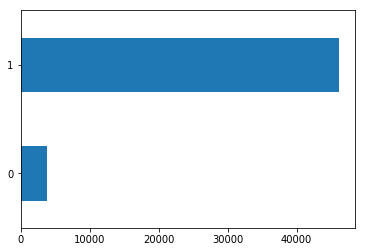

In [36]:
# Посмотрим распределение
data['rest_chain'].value_counts(ascending=True).plot(kind='barh')

## 2. Анализ данных в колонке 'city'

In [37]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['city']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
city    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [38]:
# Пропусков в данном столбце нет, данные в этой колонке являются важной составляющей для создания новых признаков
# Для данного столбца больше всего подойдет метод Encoding, сделаем dummy переменную:
# Создадим дубль колонки для dummy, т.к. 'city' еще нам пригодиться 
data['city_enc'] = data['city']
data = pd.get_dummies(data, columns=['city_enc'], dummy_na=True)
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,city_enc_Oslo,city_enc_Paris,city_enc_Porto,city_enc_Prague,city_enc_Rome,city_enc_Stockholm,city_enc_Vienna,city_enc_Warsaw,city_enc_Zurich,city_enc_nan
43960,id_4739,Madrid,['Turkish'],4742.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187514-d8798833-Reviews-Do...,d8798833,1,...,0,0,0,0,0,0,0,0,0,0
4193,id_4193,Rome,['Italian'],3131.0,$,121.0,"[['Nice diner at Al Brigante !', 'Not good at ...",/Restaurant_Review-g187791-d6575627-Reviews-Al...,d6575627,0,...,0,0,0,0,1,0,0,0,0,0


In [39]:
# Создадим признак по подсчету ресторанов в городе:
city_count = data['city'].value_counts(ascending=False)
data['rest_city_count'] = data['city'].apply(lambda x: city_count[x])

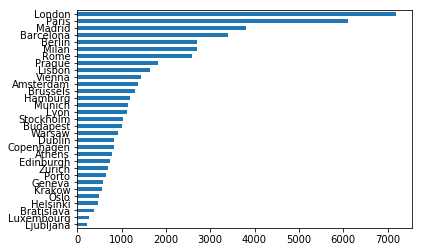

In [40]:
# Проверим распределение признака
data['city'].value_counts(ascending=True).plot(kind='barh')

Заметим, что самое большое количество ресторанов в датасете относятся к Лондону и Парижу

## 3. Анализ данных в колонке 'cuis_style'

In [41]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['cuis_style']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
cuis_style    38410 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


OtherВ данном признаке очень много пропусков 11590, это примерно 23% от общего числа строк

При удалении потеряется слишком много данных, пока заполним пропуски на значение "Other". 

Есть еще 3 варианта: 

1 - посмотреть к какому городу и стране относится ресторан и поставить их традиционную кухню, но с этим можно не угадать, поэтому попробуем подставить "Other"
    
2 - посмотреть какая кухня в сети ресторанов (в итоге у всех разная), пример:
    #data.loc[data['rest_id'] == 'id_1291']
    
3 - Написать парсер и вытащить данные с сайта, но данный путь еще не познан)

In [42]:
# Заполним пропуски
data['cuis_style'] = data['cuis_style'].fillna('European')

In [43]:
# Создадим признак по подсчету количества кухонь для каждого ресторана:
data['cuis_style_count'] = data['cuis_style'].apply(lambda x: len(x.strip('[]').replace("'","").split(", ")))
data.sample(5)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,city_enc_Porto,city_enc_Prague,city_enc_Rome,city_enc_Stockholm,city_enc_Vienna,city_enc_Warsaw,city_enc_Zurich,city_enc_nan,rest_city_count,cuis_style_count
30974,id_12357,London,['Thai'],12367.0,NaN,NaN,"[['Great Thai food'], ['01/02/2013']]",/Restaurant_Review-g186338-d3695854-Reviews-Th...,d3695854,1,...,0,0,0,0,0,0,0,0,7193,1
36060,id_21,Lisbon,"['Mediterranean', 'European', 'Portuguese', 'V...",22.0,$$$$,546.0,"[['Birthday Dinner', 'Superb Dining'], ['02/25...",/Restaurant_Review-g189158-d697284-Reviews-Cas...,d697284,1,...,0,0,0,0,0,0,0,0,1647,5
19702,id_2559,Paris,"['French', 'European', 'Healthy', 'Vegetarian ...",2560.0,$$ - $$$,152.0,"[['Amazing vegan food', 'A very nice place'], ...",/Restaurant_Review-g187147-d11661326-Reviews-P...,d11661326,1,...,0,0,0,0,0,0,0,0,6108,6
29248,id_1013,Warsaw,"['Polish', 'European', 'Czech', 'Hungarian']",1014.0,$,4.0,"[[], []]",/Restaurant_Review-g274856-d10544216-Reviews-C...,d10544216,1,...,0,0,0,0,0,1,0,0,925,4
31454,id_14488,London,['Cafe'],14499.0,$$ - $$$,18.0,"[['Delicious food', 'Agressive Proprietor'], [...",/Restaurant_Review-g186338-d4107838-Reviews-To...,d4107838,1,...,0,0,0,0,0,0,0,0,7193,1


In [44]:
# Посмотрим самые популярные кухни
data1 = data.copy()
data1['cuis_style'] = data1['cuis_style'].apply(lambda x: x.strip('[]').replace("'","").split(", "))
data1['cuis_style'].explode().value_counts()

European               24151
Vegetarian Friendly    14021
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Xinjiang                   1
Latvian                    1
Burmese                    1
Salvadoran                 1
Name: cuis_style, Length: 125, dtype: int64

Как вариант можно было бы классифицировать кухни по популярности

In [45]:
#Классифицируем как 1 - топ 5 кухонь, остальное 0.
lst_cuis_style = (data1['cuis_style'].explode()).to_list()
counter = Counter(lst_cuis_style)
lst_cuis_style5 = counter.most_common(10)
lst_cuis_top5 = []
for i in lst_cuis_style5:
    lst_cuis_top5.append(i[0])   

data['cuis_style'] = data['cuis_style'].apply(lambda x: str(x).strip('[]').replace("'","").split(", "))
data['cuis_style_top5'] = data['cuis_style'].apply(lambda x: 1 if any([cuis in lst_cuis_top5 for cuis in x]) else 0)
data.sample(5)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,city_enc_Prague,city_enc_Rome,city_enc_Stockholm,city_enc_Vienna,city_enc_Warsaw,city_enc_Zurich,city_enc_nan,rest_city_count,cuis_style_count,cuis_style_top5
653,id_653,Vienna,"[Italian, French, Cafe, Mediterranean, Soups]",1549.0,$,3.0,"[['Wonderfully friendly local cafe'], ['12/01/...",/Restaurant_Review-g190454-d12068318-Reviews-U...,d12068318,0,...,0,0,0,1,0,0,0,1443,5,1
18231,id_1079,Helsinki,[Italian],1080.0,NaN,4.0,[['Leaves something to be desired in atmopher....,/Restaurant_Review-g189934-d877267-Reviews-L_o...,d877267,1,...,0,0,0,0,0,0,0,475,1,1
11698,id_1930,Madrid,"[Contemporary, Mediterranean]",1932.0,$$ - $$$,31.0,"[['Very Modern , Great location', 'Nice and qu...",/Restaurant_Review-g187514-d11810588-Reviews-T...,d11810588,1,...,0,0,0,0,0,0,0,3813,2,1
27733,id_1382,Edinburgh,"[Cafe, British, Scottish]",1383.0,NaN,15.0,[['A delightful place in a hidden part of the....,/Restaurant_Review-g186525-d2338076-Reviews-Ca...,d2338076,1,...,0,0,0,0,0,0,0,745,3,0
37552,id_11218,London,[Italian],11228.0,$$ - $$$,18.0,"[['Great place!', ""You won't find service like...",/Restaurant_Review-g186338-d7989716-Reviews-La...,d7989716,1,...,0,0,0,0,0,0,0,7193,1,1


In [46]:
# Посмотрим какие кухни вошли в топ 10:
counter.most_common(10)

[('European', 24151),
 ('Vegetarian Friendly', 14021),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502)]

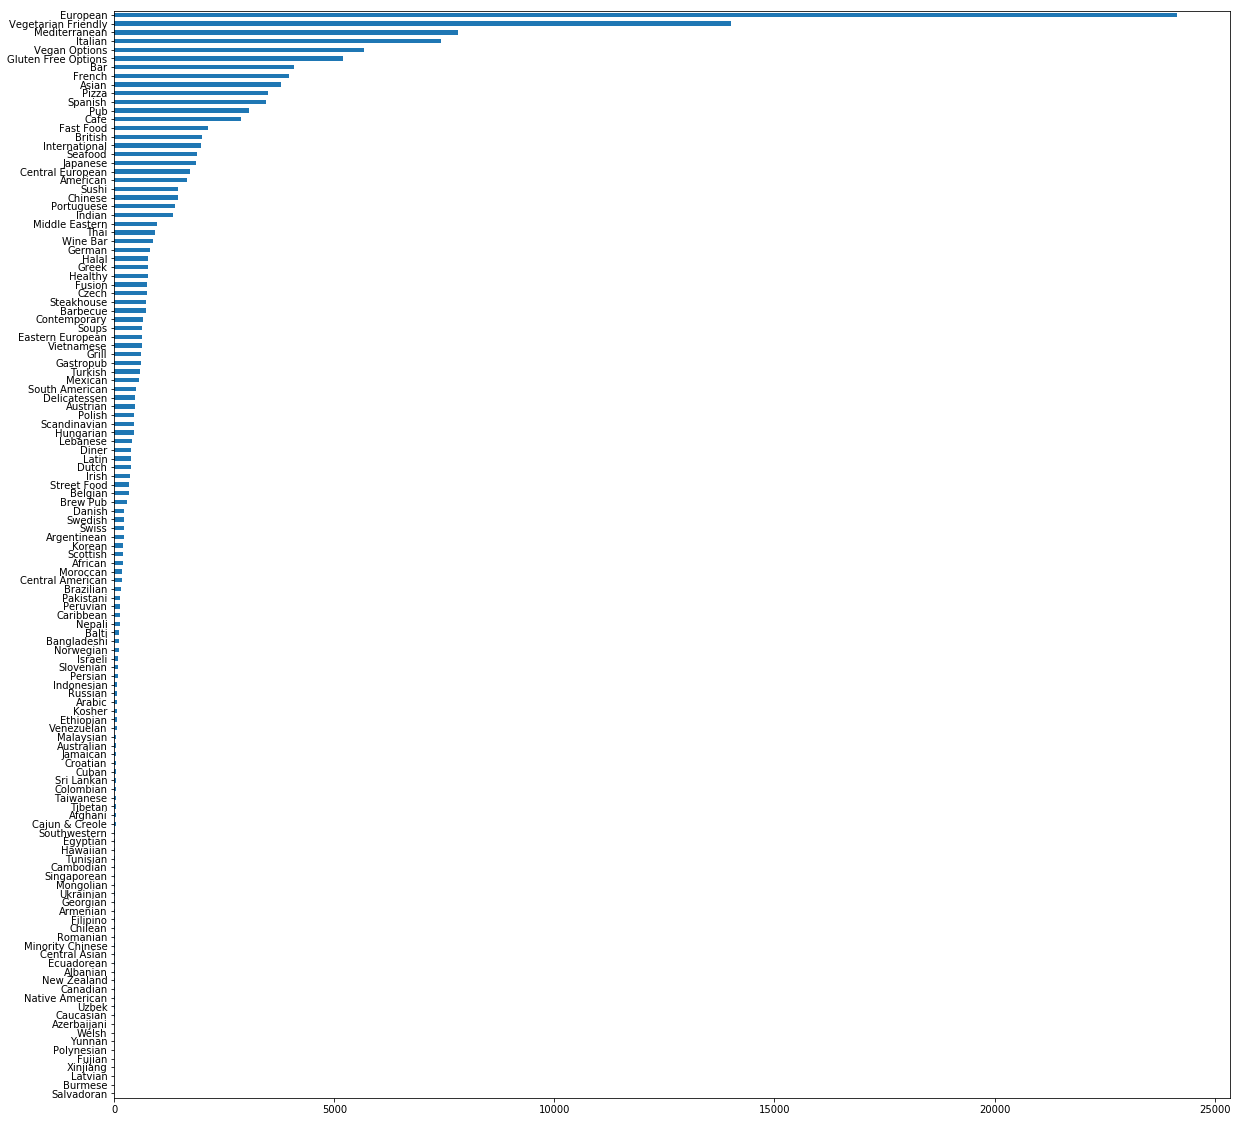

In [47]:
# Проверим распределение признака
plt.figure(figsize=(20, 20))

(data1['cuis_style'].explode()).value_counts(ascending=True).plot(kind='barh')

In [48]:
# Добавим признак, входит ли ли кухня в топ 5 или нет
for i in range(len(lst_cuis_top5)):
    name_column = ("cuis_" + lst_cuis_top5[i]).replace(' ','_').lower()
    cuis = lst_cuis_top5[i]
    data[name_column] = data['cuis_style'].apply(lambda x: 1 if cuis in x else 0)

# Остальные кухни объединим в общий признак
def get_other_cuis(row):
    '''Функция проверяет наличие в строке кухни в списке топ 5'''
    for i in lst_cuis_top5:
        if i in row:
            return 0
    return 1

data['cuis_other'] = data['cuis_style'].apply(get_other_cuis)
data.sample(5)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_vegetarian_friendly,cuis_mediterranean,cuis_italian,cuis_vegan_options,cuis_gluten_free_options,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other
42070,id_1004,Warsaw,"[Italian, Pizza, Mediterranean]",1005.0,NaN,20.0,"[['Great place for meeting old friends', 'Extr...",/Restaurant_Review-g274856-d697124-Reviews-Na_...,d697124,1,...,0,1,1,0,0,0,0,0,1,0
10438,id_2469,Brussels,[European],2470.0,NaN,7.0,"[[""Nice small gay bar in one of Brussels' gay....",/Restaurant_Review-g188644-d8073030-Reviews-Le...,d8073030,1,...,0,0,0,0,0,0,0,0,0,0
19123,id_2218,Stockholm,"[French, European, Swedish]",2221.0,$$ - $$$,8.0,"[['Relaxing ambience. Good food.'], ['07/24/20...",/Restaurant_Review-g189852-d12590186-Reviews-L...,d12590186,1,...,0,0,0,0,0,0,1,0,0,0
4832,id_4832,Copenhagen,[European],1655.0,NaN,11.0,"[[], []]",/Restaurant_Review-g189541-d3422053-Reviews-Re...,d3422053,0,...,0,0,0,0,0,0,0,0,0,0
42001,id_9517,London,[European],9526.0,NaN,2.0,"[['Cute little local', 'Doing my lunch break n...",/Restaurant_Review-g186338-d12032969-Reviews-S...,d12032969,1,...,0,0,0,0,0,0,0,0,0,0


## 4. Анализ данных в колонке 'price_range'

In [49]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['price_range']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
price_range    32639 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [50]:
'''
В данном признаке очень много пропусков 17361, это примерно 35% от общего числа строк
При удалении потеряется слишком много данных, заполним столбец модой. 
Остальные варианты по заполнению как у столбца 'cuis_style'
'''
data['price_range'].fillna(data['price_range'].mode()[0], inplace=True)

In [51]:
# Создадим признак по ценовому рангу ресторана, приведем его к категориальной переменной:
data['price_range'] = data['price_range'].apply(lambda x: 1 if x=='$' else 2 if x=='$$ - $$$' else 3)

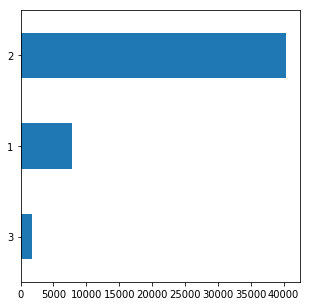

In [52]:
# Проверим распределение признака
plt.figure(figsize=(5, 5))

data['price_range'].value_counts(ascending=True).plot(kind='barh')

## 5. Анализ данных в колонке 'reviews'

In [53]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['reviews']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
reviews    49998 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [54]:
# В датасете есть 2 пропуска, заполним их пустыми скобками
data['reviews'] = data['reviews'].fillna('[[], []]')

In [55]:
# Можно было бы создать признак по тональности отзывов, но пока его отложим
# В данном признаке будем работать с датами
# Создадим новую колонку, куда вытащим только даты
data['reviews_date'] = data['reviews'].apply(lambda x: re.findall(r"\d{2}/\d{2}/\d{4}", x))
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_mediterranean,cuis_italian,cuis_vegan_options,cuis_gluten_free_options,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date
17347,id_1353,Edinburgh,[European],1354.0,2,2.0,"[['Lovely relaxing coffee shop', 'More than a ...",/Restaurant_Review-g186525-d10275948-Reviews-T...,d10275948,1,...,0,0,0,0,0,0,0,0,0,"[08/21/2016, 05/05/2016]"
24643,id_13110,Paris,"[French, European, Bar]",13112.0,2,69.0,"[['Bad service', 'Took a chance...'], ['01/05/...",/Restaurant_Review-g187147-d4787278-Reviews-Br...,d4787278,1,...,0,0,0,0,1,1,0,0,0,"[01/05/2018, 10/26/2017]"


In [56]:
# Разделим даты и преобразуем строки в нужный формат для обработки дат
data['first_reviews_date'] = data['reviews_date'].apply(lambda x: pd.to_datetime(x).min())
data['last_reviews_date'] = data['reviews_date'].apply(lambda x: pd.to_datetime(x).max())
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_vegan_options,cuis_gluten_free_options,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date
27148,id_2598,Munich,[European],2617.0,2,3.0,"[['not good not bad', 'Good and Healthy Salad'...",/Restaurant_Review-g187309-d11827742-Reviews-D...,d11827742,1,...,0,0,0,0,0,0,0,"[06/11/2017, 07/25/2017]",2017-06-11,2017-07-25
7859,id_7859,Hamburg,[European],1815.0,2,32.0,"[['A great taste and friendly staff', 'Super i...",/Restaurant_Review-g187331-d1340322-Reviews-Po...,d1340322,0,...,0,0,0,0,0,0,0,"[08/23/2016, 12/11/2015]",2015-12-11,2016-08-23


In [57]:
# Добавим признак - количество дней между последним и предпоследним отзывом
data['reviews_date_betw'] = (data['last_reviews_date'] - data['first_reviews_date']).apply(lambda x: x.days)
data['reviews_date_betw'].fillna(round(data['reviews_date_betw'].mean()), inplace=True)
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_gluten_free_options,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw
43330,id_1857,Lisbon,"[European, Portuguese]",1860.0,2,3.0,"[['Very simple and true', 'Be local - eat loca...",/Restaurant_Review-g189158-d12528042-Reviews-L...,d12528042,1,...,0,0,0,0,0,0,"[10/02/2017, 07/24/2017]",2017-07-24,2017-10-02,70.0
20964,id_1934,Barcelona,"[Mediterranean, International, European, Spanish]",1935.0,2,195.0,"[['Excellent food and excellent service!', 'Tr...",/Restaurant_Review-g187497-d6600118-Reviews-Ba...,d6600118,1,...,0,0,0,0,0,0,"[08/24/2015, 05/29/2015]",2015-05-29,2015-08-24,87.0


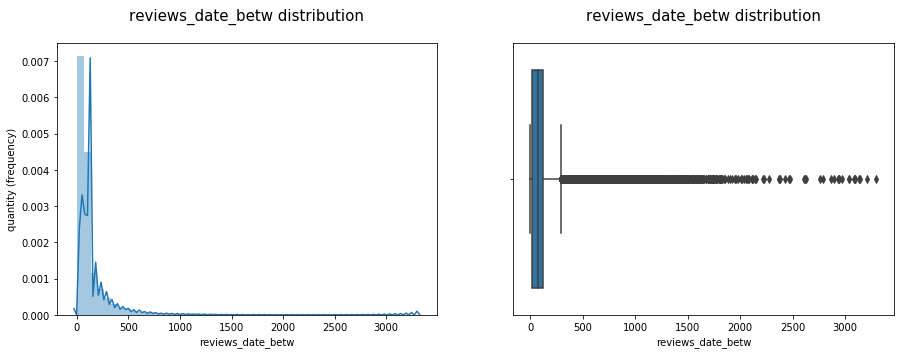

In [58]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot('reviews_date_betw')

In [59]:
# Проверим выбросы по формуле
outlier_diag(data['reviews_date_betw'])

 25-й перцентиль: 13.0,
 75-й перцентиль: 123.0,
 IQR: 110.0,  Границы выбросов: [-152.0, 288.0],
 Количество выбросов снизу:0,
 Процент выбросов снизу:0.0%,
 Количество выбросов сверху:4829,
 Процент выбросов сверху:9.658%.


In [60]:
# Посмотрим количество выбросов reviews_date_betw
len(data.loc[data['reviews_date_betw']>=outlier_high(data['reviews_date_betw'])])

4829

In [61]:
# Добавим признак - сколько дней прошло с момета последнего отзыва
data['last_reviews_date_to_now'] = (datetime.datetime.now() - data['last_reviews_date']).apply(lambda x: x.days)
data['last_reviews_date_to_now'].fillna(round(data['last_reviews_date_to_now'].mean()), inplace=True)
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now
31929,id_1932,Stockholm,"[Japanese, Asian]",1935.0,2,2.0,"[['Fresh, hot, wonderful dumplings!'], ['03/19...",/Restaurant_Review-g189852-d10459951-Reviews-B...,d10459951,1,...,0,0,1,0,0,[03/19/2017],2017-03-19,2017-03-19,0.0,1597.0
32847,id_2,Prague,"[International, Bar, Vegetarian Friendly, Glut...",3.0,2,797.0,"[['NYE 2018', 'Just the coolest cocktails ever...",/Restaurant_Review-g274707-d6494862-Reviews-Be...,d6494862,1,...,1,0,0,0,0,"[01/01/2018, 01/01/2018]",2018-01-01,2018-01-01,0.0,1309.0


In [62]:
# Посмотрим на значения нового признака
data['last_reviews_date_to_now'].describe()

count    50000.000000
mean      1543.038000
std        332.473265
min       1253.000000
25%       1344.000000
50%       1457.000000
75%       1543.000000
max       6312.000000
Name: last_reviews_date_to_now, dtype: float64

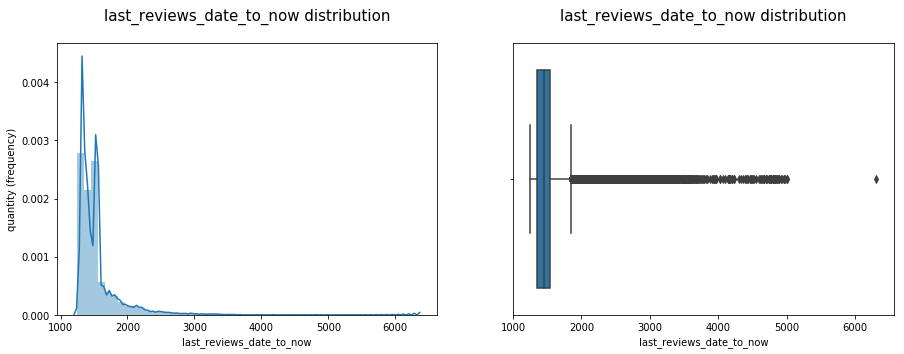

In [63]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot('last_reviews_date_to_now')

In [64]:
# Проверим выбросы по формуле
outlier_diag(data['last_reviews_date_to_now'])

 25-й перцентиль: 1344.0,
 75-й перцентиль: 1543.0,
 IQR: 199.0,  Границы выбросов: [1045.5, 1841.5],
 Количество выбросов снизу:0,
 Процент выбросов снизу:0.0%,
 Количество выбросов сверху:5503,
 Процент выбросов сверху:11.006%.


In [65]:
# Посмотрим количество выбросов
len(data.loc[data['last_reviews_date_to_now']>=outlier_high(data['last_reviews_date_to_now'])])

5503

In [66]:
# Проверим самый большой выброс
data.loc[data['last_reviews_date_to_now']==6311.000000]

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now


In [67]:
# Сервис основан в феврале 2000 года, поэтому данный отзыв имеет место быть
# Проверим есть ли отзывы в колонке с датой, которая могла бы быть некорректной, т.е. до основания сервиса
data.loc[data['first_reviews_date']<'2000-02-01']

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now


In [68]:
# Проверим есть ли отзывы в колонке с датой, которая могла бы быть некорректной, т.е. до основания сервиса
data.loc[data['last_reviews_date']<'2000-02-01']

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now


Некорректных дат нет.

В колонке last_reviews_date - 5503 выброса (11%), reviews_date_betw - 4829(9.6%). Слишком много данных потеряем при удалении. Плюс все даты отзывов лежат выше даты основания сайта, пэтому их можно ситать "валидными". 

## 6. Анализ данных в колонке 'num_reviews'

In [69]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['num_reviews']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
num_reviews    46800 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


In [70]:
# В данном признаке присутствуют пропуски 3200 строк, это 6.4% от общего числа
# Заполним их 0, будем предполагать, что у данного ресторана не было отзывов
data['num_reviews'].fillna(0, inplace=True)
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now
16230,id_2480,Vienna,"[Italian, Austrian, European]",2482.0,2,8.0,"[['Nice italian restaurant', 'Neighborhood piz...",/Restaurant_Review-g190454-d6481956-Reviews-Da...,d6481956,1,...,0,0,0,0,0,"[10/29/2014, 08/22/2014]",2014-08-22,2014-10-29,68.0,2469.0
21284,id_1603,Budapest,"[Fusion, European, Cafe, Mediterranean, Hungar...",1604.0,2,21.0,"[['Super food, family atmosphere!!', 'Great pl...",/Restaurant_Review-g274887-d7218192-Reviews-Kl...,d7218192,1,...,0,0,0,0,0,"[07/28/2017, 07/28/2017]",2017-07-28,2017-07-28,0.0,1466.0


In [71]:
len(data.loc[data['num_reviews']==0])

3200

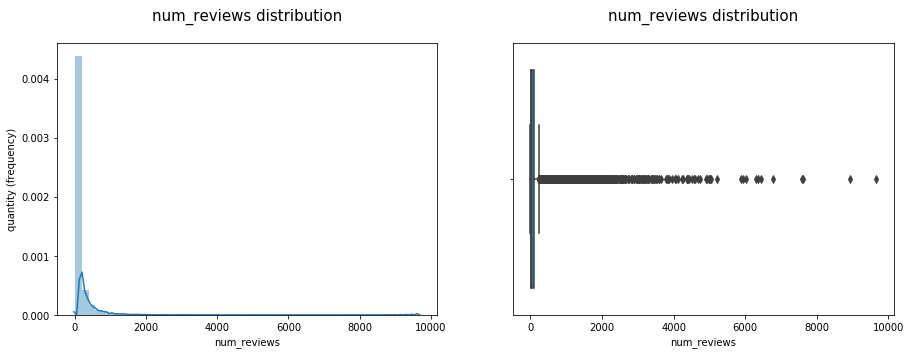

In [72]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot('num_reviews')

In [73]:
# Проверим выбросы по формуле
outlier_diag(data['num_reviews'])

 25-й перцентиль: 7.0,
 75-й перцентиль: 105.0,
 IQR: 98.0,  Границы выбросов: [-140.0, 252.0],
 Количество выбросов снизу:0,
 Процент выбросов снизу:0.0%,
 Количество выбросов сверху:5975,
 Процент выбросов сверху:11.95%.


В колонке num_reviews - 5975 выброса (11,95%). Слишком много данных потеряем при удалении. Такое кол-во выбросов появилось за счет большого количества отсутствующих отзывов. В данном признаке удалять выбросы не будем.

## 7. Анализ данных в колонке 'url_ta'

Данный признак использоваться в анализе не будет, т.к. парсер разрабатываться не будет.

## 8. Анализ данных в колонке 'id_ta'

In [74]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['id_ta']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
id_ta    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [75]:
# В данном признаке пропусков нет
# Данный признак похож на то, что это как раз униакльный код ресторана на TripAdvisor
# В данном признаке имеет смысл проверить только есть ли дубли или нет
lst_id_count = data['id_ta'].to_list()
count_id = Counter(lst_id_count)
# Создадим новый признак по учету дублей
data['id_ta_double'] = data['id_ta'].apply(lambda x: 1 if count_id.setdefault(x)>1 else 0)
data.loc[data['id_ta_double'] == 1]

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double
118,id_118,Warsaw,[Italian],1801.0,1,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,...,0,0,0,0,[],NaT,NaT,123.0,1543.0,1
704,id_704,Madrid,[European],6274.0,2,21.0,"[[], []]",/Restaurant_Review-g187514-d5617412-Reviews-Gr...,d5617412,0,...,0,0,0,0,[],NaT,NaT,123.0,1543.0,1
1171,id_1171,Madrid,"[Indian, Asian, Nepali, Vegetarian Friendly]",1219.0,2,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,d12488993,0,...,0,1,0,0,"[01/07/2018, 11/08/2017]",2017-11-08,2018-01-07,60.0,1303.0,1
1423,id_1423,Madrid,"[Chinese, Japanese, Sushi, Asian, Thai, Vietna...",1220.0,2,159.0,"[['Excellent cuisine, friendly and helpful se....",/Restaurant_Review-g187514-d2010743-Reviews-Re...,d2010743,0,...,0,1,0,0,"[12/25/2016, 06/05/2016]",2016-06-05,2016-12-25,203.0,1681.0,1
2654,id_2654,Madrid,"[Chinese, Japanese, Asian]",3146.0,2,53.0,"[['Excellent food food', 'Fantastic sushi serv...",/Restaurant_Review-g187514-d4914988-Reviews-Xi...,d4914988,0,...,0,1,0,0,"[09/07/2016, 02/21/2016]",2016-02-21,2016-09-07,199.0,1790.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46934,id_3140,Madrid,"[Japanese, Sushi, Asian, Thai]",3142.0,2,77.0,"[['Great Asian Option', 'Wow'], ['10/16/2017',...",/Restaurant_Review-g187514-d2360290-Reviews-Lo...,d2360290,1,...,0,1,0,0,"[10/16/2017, 09/07/2016]",2016-09-07,2017-10-16,404.0,1386.0,1
48946,id_3242,Madrid,[European],3244.0,2,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,...,0,0,0,0,[],NaT,NaT,123.0,1543.0,1
48967,id_1238,Madrid,"[Indian, Asian, Nepali, Vegetarian Friendly]",1240.0,2,22.0,"[['Fantastic food, Excellent service', 'Surpri...",/Restaurant_Review-g187514-d12488993-Reviews-K...,d12488993,1,...,0,1,0,0,"[01/07/2018, 11/08/2017]",2017-11-08,2018-01-07,60.0,1303.0,1
49797,id_3001,Madrid,"[Diner, Mediterranean, Spanish, Bar]",3003.0,1,71.0,"[['Very cozy!', 'Service rate: 1'], ['01/17/20...",/Restaurant_Review-g187514-d3647024-Reviews-La...,d3647024,1,...,0,0,0,0,"[01/17/2016, 11/18/2015]",2015-11-18,2016-01-17,60.0,2024.0,1


В датасете 74 дубля ресторананов, удалять данные строки не будем, но оставим признак.

## 9. Анализ данных в колонке 'country'

In [76]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
country    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [77]:
# Пропусков в данной колонеке нет
# Создадим признак количество ресторанов стране
country_count = data['country'].value_counts(ascending=False)
data['rest_country_count'] = data['country'].apply(lambda x: country_count[x])
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_asian,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count
15448,id_8452,Madrid,[European],8459.0,2,12.0,"[['A horrendous experience'], ['08/23/2016']]",/Restaurant_Review-g187514-d5795047-Reviews-El...,d5795047,1,...,0,0,0,[08/23/2016],2016-08-23,2016-08-23,0.0,1805.0,0,7208
37082,id_62,Oslo,"[Bar, Pub, International]",63.0,2,214.0,"[['Craft Beer', 'Great beer, and the Best PORK...",/Restaurant_Review-g190479-d3724405-Reviews-Cr...,d3724405,1,...,0,0,0,"[01/06/2018, 12/26/2017]",2017-12-26,2018-01-06,11.0,1304.0,0,488


In [78]:
data['rest_country_count'].max()

7938

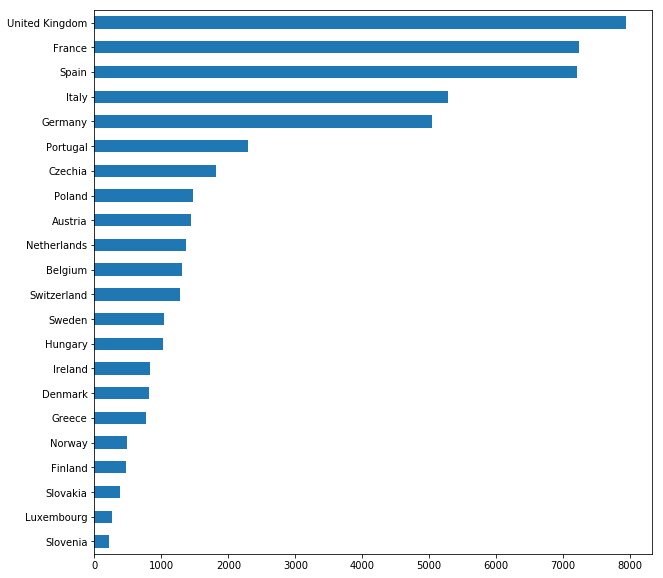

In [79]:
# Посмотрим распределение и выбросы на графиках
plt.figure(figsize=(10, 10))
data['country'].value_counts(ascending=True).plot(kind='barh')

In [80]:
# Сделаем колонку с категориальным признаком
le = LabelEncoder()
le.fit(data['country'])
data['country_code'] = le.transform(data['country'])
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code
29304,id_887,Berlin,"[Asian, Vietnamese, Vegetarian Friendly, Vegan...",888.0,2,192.0,"[['very beautiful interior, good food', 'Revie...",/Restaurant_Review-g187323-d804217-Reviews-Si_...,d804217,1,...,0,0,"[08/24/2017, 05/12/2017]",2017-05-12,2017-08-24,104.0,1439.0,0,5036,6
47646,id_1521,Dublin,[Pub],1525.0,2,4.0,"[['Perfect for a drink and a chat', 'Proper ol...",/Restaurant_Review-g186605-d7231601-Reviews-Ga...,d7231601,1,...,0,1,"[11/27/2017, 02/06/2017]",2017-02-06,2017-11-27,294.0,1344.0,0,836,9


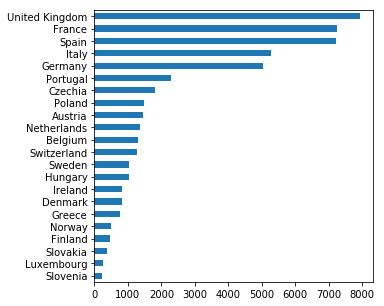

In [81]:
# Проверим распределение признака
plt.figure(figsize=(5, 5))

(data1['country'].explode()).value_counts(ascending=True).plot(kind='barh')

## 10. Анализ данных в колонке 'capital'

In [82]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['capital']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
capital    49255 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [83]:
# Наблюдаем в данном признаке пропуски
# Проверим колонку 'capital'
capital_check = data.loc[data['capital'].isna()]
capital_check['city'].unique()

array(['Edinburgh'], dtype=object)

In [84]:
# Значит пропуски только у Эдинбурга, город является столицей Шотландии, исправим:
data['capital'].fillna('primary', inplace = True)

In [85]:
# Перезапишем признак в столице ресторан или нет, сделаем из него категориальную переменную
data['capital'] = data['capital'].apply(lambda x: 1 if x=='primary' else 0)
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_pizza,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code
21542,id_1804,Milan,[European],1806.0,2,48.0,"[['A gem spot out of nowhere', 'The best Negro...",/Restaurant_Review-g187849-d4883948-Reviews-Se...,d4883948,1,...,0,0,"[05/29/2017, 12/21/2016]",2016-12-21,2017-05-29,159.0,1526.0,0,5283,10
32425,id_1941,Hamburg,"[Japanese, Sushi]",1945.0,2,13.0,"[[], []]",/Restaurant_Review-g187331-d2546507-Reviews-So...,d2546507,1,...,0,1,[],NaT,NaT,123.0,1543.0,0,5036,6


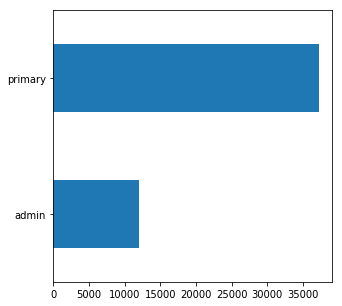

In [86]:
# Проверим распределение признака
plt.figure(figsize=(5, 5))

(data1['capital'].explode()).value_counts(ascending=True).plot(kind='barh')

## 11. Анализ данных в колонке 'population'

In [87]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['population']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
population    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


Пропусков в данном признаке нет, оставим его для анализа как есть

In [88]:
data['population']

0        11020000.0
1          642045.0
2          488050.0
3        10979000.0
4          429564.0
            ...    
49995     1366180.0
49996    11020000.0
49997      972647.0
49998     1790658.0
49999     1366180.0
Name: population, Length: 50000, dtype: float64

## 12. Анализ данных в колонке 'rank'

In [89]:
# Посмотрим есть ли незаполненные ячейки
data.loc[:,['rank']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
rank    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


In [90]:
# Пропусков в данном столбце нет
# Посмотрим как данный признак коррелирует с отстальными
data.corr()

,rank,price_range,num_reviews,sample,Rating,population,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,...,cuis_bar,cuis_french,cuis_asian,cuis_pizza,cuis_other,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code
rank,1.000000,-0.026334,-0.223198,6.270720e-03,-0.109897,0.691856,0.202905,-0.502592,-0.094100,-0.094479,...,-0.038871,0.041533,-0.005595,-0.039910,0.152890,0.096122,0.181775,-0.010659,0.569709,0.231227
price_range,-0.026334,1.000000,0.107732,-3.418930e-03,-0.012176,0.017744,-0.008803,0.005652,-0.003031,-0.023953,...,-0.027180,0.095563,-0.024251,-0.083239,-0.116672,-0.018126,0.015922,0.001149,-0.000646,-0.019499
num_reviews,-0.223198,0.107732,1.000000,2.688330e-03,0.011006,0.010362,0.013941,0.061956,0.014532,-0.012802,...,0.077711,0.063983,0.029428,0.067613,-0.119148,-0.127979,-0.198118,0.005102,0.040914,0.030854
sample,0.006271,-0.003419,0.002688,1.000000e+00,0.936543,0.005653,0.004400,0.079858,-0.003550,0.002912,...,0.003975,0.002589,-0.003364,0.009286,0.000497,-0.006567,-0.003425,-0.002861,0.004896,0.002769
Rating,-0.109897,-0.012176,0.011006,9.365435e-01,1.000000,-0.012732,0.010620,0.150831,0.007447,0.016852,...,-0.001989,0.006533,-0.004504,-0.001764,-0.017622,-0.029072,-0.029484,0.000034,-0.015689,-0.010436
population,0.691856,0.017744,0.010362,5.653094e-03,-0.012732,1.000000,0.339328,-0.304811,-0.149405,-0.117674,...,0.028210,0.219090,0.061116,-0.040897,0.055199,-0.012551,-0.018855,0.011346,0.764444,0.257842
capital,0.202905,-0.008803,0.013941,4.399823e-03,0.010620,0.339328,1.000000,-0.114532,0.094479,0.070623,...,0.045914,0.051271,0.052535,-0.011431,0.022538,-0.032198,-0.039011,0.021655,-0.068028,-0.073787
rest_chain,-0.502592,0.005652,0.061956,7.985763e-02,0.150831,-0.304811,-0.114532,1.000000,0.030219,0.022624,...,0.011198,-0.016100,-0.016457,0.016145,-0.065605,-0.035060,-0.058834,0.003206,-0.202095,-0.117222
city_enc_Amsterdam,-0.094100,-0.003031,0.014532,-3.550404e-03,0.007447,-0.149405,0.094479,0.030219,1.000000,-0.021090,...,0.055217,-0.007217,0.027819,-0.012038,-0.017076,-0.036476,-0.041454,-0.006467,-0.213432,0.008987
city_enc_Athens,-0.094479,-0.023953,-0.012802,2.912415e-03,0.016852,-0.117674,0.070623,0.022624,-0.021090,1.000000,...,-0.005629,-0.033881,-0.019424,-0.018608,0.033119,-0.003260,0.002599,-0.004834,-0.186735,-0.085599


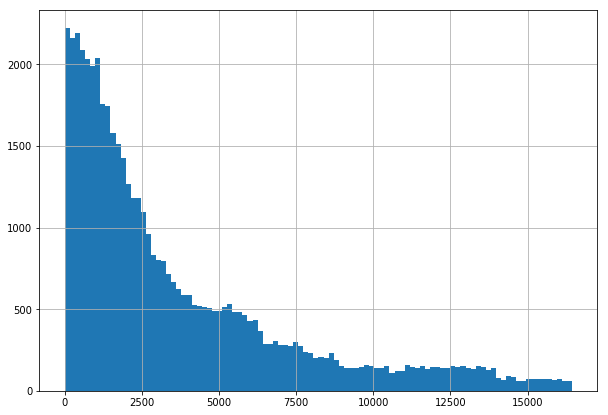

In [91]:
#Посмотрим распределение признака
plt.rcParams['figure.figsize'] = (10,7)
data['rank'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе.

На основе анализа таблицы корреляции сделаем вывод, что нормировать признак лучше по следующим столбцам: 'num_reviews', 'population', 'rest_city_count', 'rest_chain_count', 'rest_country_count'

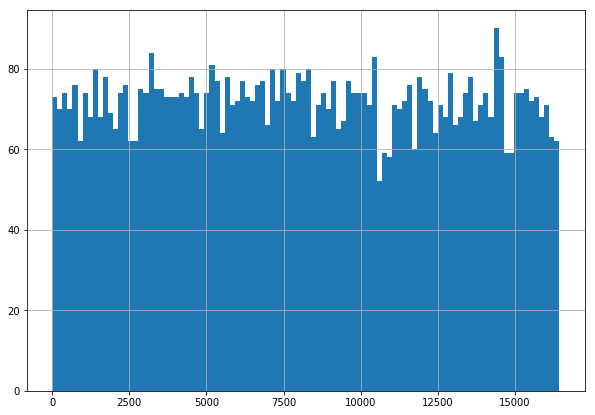

In [92]:
# Посмотрим распределение признака по Лондону
data['rank'][data['city'] =='London'].hist(bins=100)

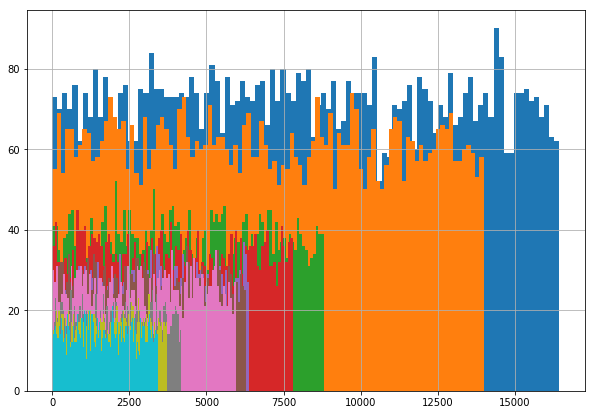

In [93]:
# Посмотрим на топ 10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['rank'][data['city'] == x].hist(bins=100)
plt.show()

In [94]:
# Группируем ранг по городам 
mean_rank_city_gr = data.groupby(['city'])['rank'].mean()
data['mean_rank_city'] = data['city'].apply(lambda x: mean_rank_city_gr[x])
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,cuis_other,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city
12405,id_216,Budapest,"[Japanese, Seafood, Sushi, Asian, Vegetarian F...",217.0,2,156.0,"[['Tasty foods, but dirty toilets', 'Birthday ...",/Restaurant_Review-g274887-d10162899-Reviews-W...,d10162899,1,...,0,"[11/20/2017, 10/16/2017]",2017-10-16,2017-11-20,35.0,1351.0,0,1021,8,1219.061704
33856,id_3881,Madrid,[Cafe],3883.0,2,7.0,"[[], []]",/Restaurant_Review-g187514-d8287507-Reviews-Ba...,d8287507,1,...,1,[],NaT,NaT,123.0,1543.0,0,7208,18,4388.516391


In [95]:
# Центрируем "ранг" по сгруппированному по городам его же значения
data['rank_cent'] = data['rank'] - data['mean_rank_city']
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,reviews_date,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent
17038,id_4972,Madrid,"[Mediterranean, European, Spanish]",4975.0,2,92.0,"[['Not a tourist trap', 'Convenient for Chamar...",/Restaurant_Review-g187514-d1023663-Reviews-La...,d1023663,1,...,"[05/26/2017, 03/04/2017]",2017-03-04,2017-05-26,83.0,1529.0,0,7208,18,4388.516391,586.483609
2400,id_2400,Lyon,"[Seafood, French]",2129.0,2,24.0,"[['Good value for money', 'Fine food, expensiv...",/Restaurant_Review-g187265-d2501128-Reviews-Le...,d2501128,0,...,"[03/14/2017, 07/13/2014]",2014-07-13,2017-03-14,975.0,1602.0,0,7234,5,1303.902309,825.097691


In [96]:
# Нормируем ранг по количеству населения
data['norm_rank_population'] = data['rank_cent'] / data['population']
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,first_reviews_date,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent,norm_rank_population
37617,id_12957,London,[European],12967.0,2,4.0,"[['Great choice of food', 'Happen to just pop ...",/Restaurant_Review-g186338-d10063917-Reviews-J...,d10063917,1,...,2017-01-29,2017-04-01,62.0,1584.0,0,7938,21,8169.707354,4797.292646,0.000437
28490,id_2451,Barcelona,"[Mediterranean, Spanish]",2452.0,2,39.0,"[['Menu del dia', ""Nice decor, food wasn't gre...",/Restaurant_Review-g187497-d4062132-Reviews-Th...,d4062132,1,...,2017-10-05,2017-12-02,58.0,1339.0,0,7208,18,3879.422680,-1427.422680,-0.000311


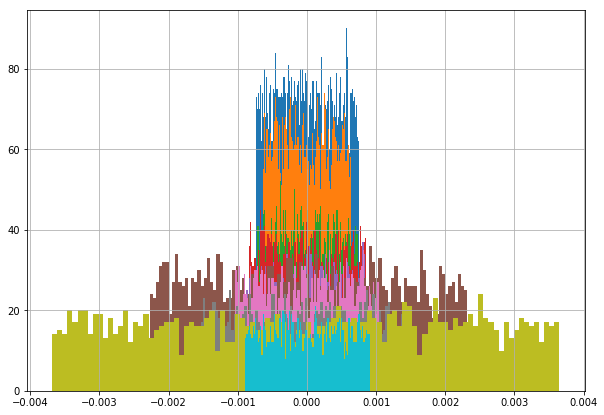

In [97]:
# Посмотрим на топ 10 городов c распределением ранга по количеству населения
for x in (data['city'].value_counts())[0:10].index:
    data['norm_rank_population'][data['city'] == x].hist(bins=100)
plt.show()

In [98]:
# Нормируем ранг по количеству ресторанов в городе
data['norm_rank_rest_city_count'] = data['rank_cent'] / data['rest_city_count']
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,last_reviews_date,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent,norm_rank_population,norm_rank_rest_city_count
24722,id_3494,Milan,[European],3496.0,2,0.0,"[[], []]",/Restaurant_Review-g187849-d12141815-Reviews-P...,d12141815,1,...,NaT,123.0,1543.0,0,5283,10,3106.027840,389.972160,0.000285,0.144756
38139,id_1145,Lyon,[European],1146.0,2,28.0,"[['Flavourful, fresh good Afghan food', 'Delic...",/Restaurant_Review-g187265-d1328180-Reviews-Az...,d1328180,1,...,2017-07-11,953.0,1483.0,0,7234,5,1303.902309,-157.902309,-0.000306,-0.140233


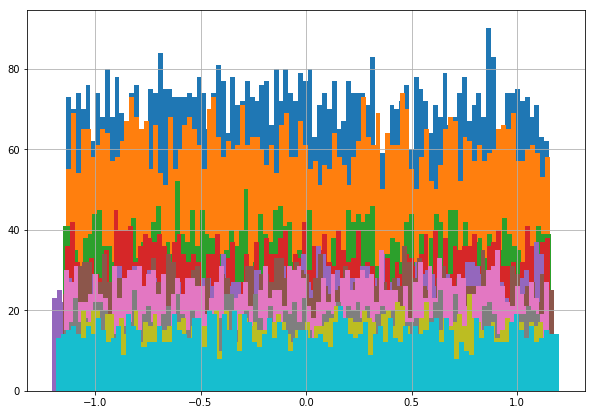

In [99]:
# Посмотрим на топ 10 городов c распределением ранга по количеству ресторанов в городе
for x in (data['city'].value_counts())[0:10].index:
    data['norm_rank_rest_city_count'][data['city'] == x].hist(bins=100)
plt.show()

In [100]:
# Нормируем ранг по количеству ресторанов в стране
data['norm_rank_rest_country_count'] = data['rank_cent'] / data['rest_country_count']
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count
36451,id_392,Oslo,"[American, Bar, Pub, European, Gluten Free Opt...",393.0,2,151.0,"[['Christine', 'Friends at lunch'], ['10/18/20...",/Restaurant_Review-g190479-d5770894-Reviews-Ho...,d5770894,1,...,98.0,1384.0,0,488,13,552.569672,-159.569672,-0.000230,-0.326987,-0.326987
39608,id_7651,Paris,"[American, Healthy, Vegetarian Friendly, Glute...",7652.0,2,194.0,"[['Good food', 'Ok Pancakes. Fun place.'], ['1...",/Restaurant_Review-g187147-d6999717-Reviews-Pa...,d6999717,1,...,48.0,1340.0,0,7234,5,6938.557138,713.442862,0.000065,0.116805,0.098624


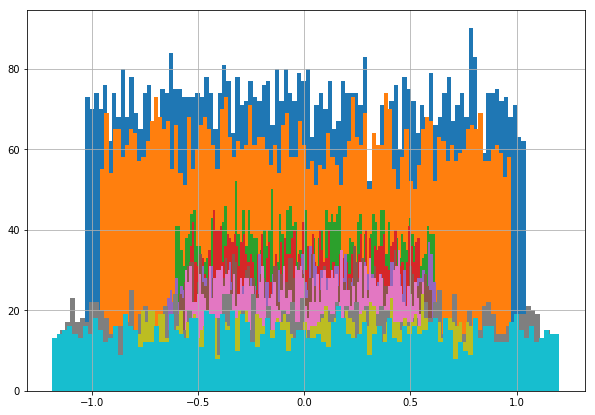

In [101]:
# Посмотрим на топ 10 городов c распределением ранга по количеству ресторанов в стране
for x in (data['city'].value_counts())[0:10].index:
    data['norm_rank_rest_country_count'][data['city'] == x].hist(bins=100)
plt.show()

In [102]:
# Нормируем ранг по количеству отзывов, кол-во отзывов с городом не связано, поэтому просто перемножим признаки
data['norm_rank_num_reviews'] = data['rank'] * data['num_reviews']
data.sample(2)

,rest_id,city,cuis_style,rank,price_range,num_reviews,reviews,url_ta,id_ta,sample,...,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
26799,id_5417,Milan,"[Italian, Pizza]",5420.0,1,55.0,"[['Lovely!', 'Affluenza restaurant'], ['08/28/...",/Restaurant_Review-g187849-d3843404-Reviews-La...,d3843404,1,...,1800.0,0,5283,10,3106.02784,2313.97216,0.001694,0.858935,0.438003,298100.0
1062,id_1062,Barcelona,"[Mediterranean, European, Spanish, Vegetarian ...",4433.0,2,58.0,"[['Only OK - 2.5 stars', 'Good'], ['12/06/2017...",/Restaurant_Review-g187497-d7195511-Reviews-Se...,d7195511,0,...,1335.0,0,7208,18,3879.42268,553.57732,0.000121,0.163057,0.076800,257114.0


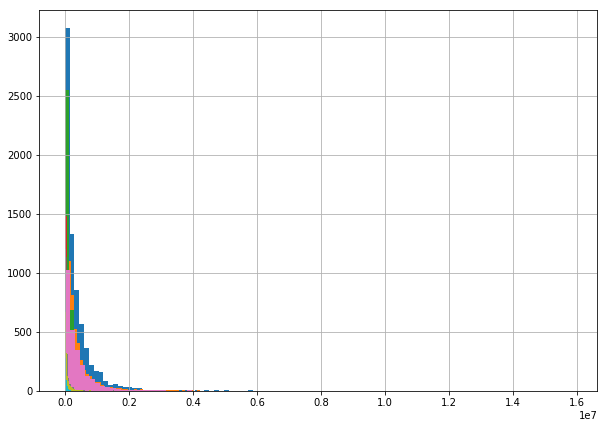

In [103]:
# Посмотрим на топ 10 городов c распределением ранга по количеству отзывов
for x in (data['city'].value_counts())[0:10].index:
    data['norm_rank_num_reviews'][data['city'] == x].hist(bins=100)
plt.show()

# Проведем корреляционный анализ количественных переменных

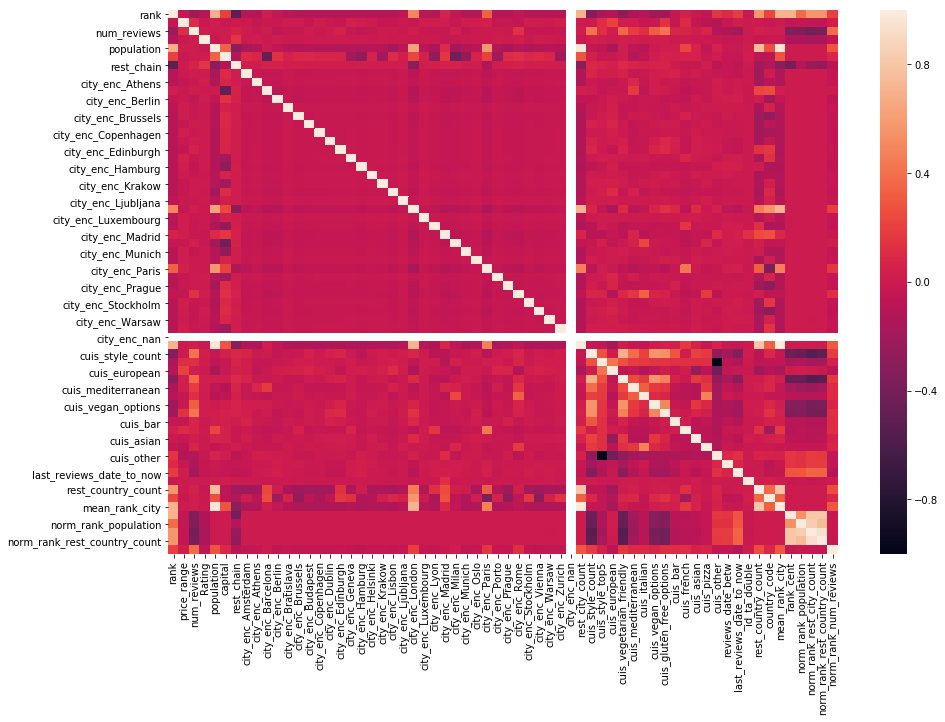

In [104]:
#Выведем корреляционную heatmap матрицу
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [105]:
#Выведем корреляционную матрицу
data.corr()

,rank,price_range,num_reviews,sample,Rating,population,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,...,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,mean_rank_city,rank_cent,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
rank,1.000000,-0.026334,-0.223198,0.006271,-0.109897,6.918564e-01,2.029052e-01,-0.502592,-9.410029e-02,-9.447931e-02,...,0.181775,-0.010659,5.697092e-01,2.312267e-01,7.090966e-01,0.705111,0.380961,0.568802,0.568108,0.197957
price_range,-0.026334,1.000000,0.107732,-0.003419,-0.012176,1.774430e-02,-8.802856e-03,0.005652,-3.030878e-03,-2.395306e-02,...,0.015922,0.001149,-6.456788e-04,-1.949869e-02,4.967909e-03,-0.042343,-0.028008,-0.044109,-0.044167,0.027911
num_reviews,-0.223198,0.107732,1.000000,0.002688,0.011006,1.036245e-02,1.394091e-02,0.061956,1.453246e-02,-1.280231e-02,...,-0.198118,0.005102,4.091386e-02,3.085377e-02,2.557277e-02,-0.342261,-0.347735,-0.406140,-0.379252,0.378961
sample,0.006271,-0.003419,0.002688,1.000000,0.936543,5.653094e-03,4.399823e-03,0.079858,-3.550404e-03,2.912415e-03,...,-0.003425,-0.002861,4.895536e-03,2.768973e-03,4.616136e-03,0.004251,-0.001260,0.001833,0.003124,0.009455
Rating,-0.109897,-0.012176,0.011006,0.936543,1.000000,-1.273196e-02,1.062048e-02,0.150831,7.447304e-03,1.685166e-02,...,-0.029484,0.000034,-1.568935e-02,-1.043569e-02,-1.473691e-02,-0.141038,-0.142445,-0.169041,-0.158194,-0.062369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rank_cent,0.705111,-0.042343,-0.342261,0.004251,-0.141038,4.193477e-19,-1.940097e-17,-0.402397,5.462242e-18,-2.943177e-18,...,0.283471,-0.023143,2.953965e-18,2.762042e-18,1.716188e-17,1.000000,0.540285,0.806683,0.805699,-0.023566
norm_rank_population,0.380961,-0.028008,-0.347735,-0.001260,-0.142445,-7.474421e-18,-2.969659e-17,-0.117006,4.193373e-17,-8.659837e-18,...,0.291619,-0.011419,-2.570967e-17,-1.511002e-17,-7.639218e-18,0.540285,1.000000,0.842148,0.746103,-0.010362
norm_rank_rest_city_count,0.568802,-0.044109,-0.406140,0.001833,-0.169041,1.543721e-18,-4.249194e-17,-0.231244,6.648576e-18,-7.308717e-18,...,0.351295,-0.021590,2.521337e-17,1.389354e-17,-1.900677e-17,0.806683,0.842148,1.000000,0.935663,-0.015244
norm_rank_rest_country_count,0.568108,-0.044167,-0.379252,0.003124,-0.158194,-2.044803e-17,-2.233704e-17,-0.271526,2.326560e-17,-1.335983e-17,...,0.339816,-0.014842,1.270613e-17,2.313153e-17,-5.677699e-19,0.805699,0.746103,0.935663,1.000000,-0.016466


In [106]:
data.columns

Index(['rest_id', 'city', 'cuis_style', 'rank', 'price_range', 'num_reviews',
       'reviews', 'url_ta', 'id_ta', 'sample', 'Rating', 'population',
       'country', 'capital', 'rest_chain', 'city_enc_Amsterdam',
       'city_enc_Athens', 'city_enc_Barcelona', 'city_enc_Berlin',
       'city_enc_Bratislava', 'city_enc_Brussels', 'city_enc_Budapest',
       'city_enc_Copenhagen', 'city_enc_Dublin', 'city_enc_Edinburgh',
       'city_enc_Geneva', 'city_enc_Hamburg', 'city_enc_Helsinki',
       'city_enc_Krakow', 'city_enc_Lisbon', 'city_enc_Ljubljana',
       'city_enc_London', 'city_enc_Luxembourg', 'city_enc_Lyon',
       'city_enc_Madrid', 'city_enc_Milan', 'city_enc_Munich', 'city_enc_Oslo',
       'city_enc_Paris', 'city_enc_Porto', 'city_enc_Prague', 'city_enc_Rome',
       'city_enc_Stockholm', 'city_enc_Vienna', 'city_enc_Warsaw',
       'city_enc_Zurich', 'city_enc_nan', 'rest_city_count',
       'cuis_style_count', 'cuis_style_top5', 'cuis_european',
       'cuis_vegetarian_fr

In [107]:
# Модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# Удалим вспомогательные колонки
data.drop(['population','rank_cent', 
           'mean_rank_city', 'first_reviews_date', 
           'last_reviews_date'], axis = 1, inplace=True)

In [108]:
data.corr().unstack().sort_values().drop_duplicates()

cuis_style_top5               cuis_other                     -1.000000
norm_rank_rest_city_count     cuis_vegetarian_friendly       -0.550415
                              cuis_style_count               -0.543000
norm_rank_rest_country_count  cuis_vegetarian_friendly       -0.521945
cuis_style_count              norm_rank_rest_country_count   -0.513346
                                                                ...   
norm_rank_rest_city_count     norm_rank_population            0.842148
norm_rank_rest_country_count  norm_rank_rest_city_count       0.935663
sample                        Rating                          0.936543
rank                          rank                            1.000000
                              city_enc_nan                         NaN
Length: 1832, dtype: float64

Из таблицы корреляций видно, что явно нельзя выделить признаки в значительной степени влияющие на целевую переменную, оставим для анализа все признаки.

#### Запускаем и проверяем что получилось

In [109]:
df_preproc = data
df_preproc.head(10)

,rank,price_range,num_reviews,sample,Rating,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,city_enc_Barcelona,...,cuis_other,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
0,12963.0,2,4.0,0,0.0,1,1,0,0,0,...,0,123.0,1543.0,0,7234,5,0.000547,0.986320,0.832796,51852.0
1,106.0,2,97.0,0,0.0,1,1,0,0,0,...,0,37.0,1336.0,0,475,4,-0.000714,-0.964698,-0.964698,10282.0
2,810.0,2,28.0,0,0.0,1,1,0,0,0,...,0,22.0,1313.0,0,7938,21,-0.000154,-0.100846,-0.009465,22680.0
3,1669.0,3,202.0,0,0.0,1,1,0,0,0,...,0,14.0,1335.0,0,7938,21,-0.000592,-0.903755,-0.818935,337138.0
4,37.0,3,162.0,0,0.0,1,1,0,0,0,...,0,15.0,1271.0,0,380,16,-0.000990,-1.119550,-1.119550,5994.0
5,5093.0,1,24.0,0,0.0,1,1,0,0,0,...,0,5.0,1425.0,0,7234,5,-0.000167,-0.302154,-0.255123,122232.0
6,3704.0,1,2.0,0,0.0,1,1,0,0,0,...,0,123.0,1543.0,0,2289,15,0.003625,1.115161,0.802390,7408.0
7,2330.0,2,0.0,0,0.0,1,1,0,0,0,...,0,123.0,1543.0,0,1021,8,0.000634,1.088088,1.088088,0.0
8,771.0,2,2.0,0,0.0,1,1,0,0,0,...,0,88.0,1303.0,0,475,4,0.000322,0.435302,0.435302,1542.0
9,605.0,2,13.0,0,0.0,1,1,0,0,0,...,0,34.0,1339.0,0,1033,19,-0.000650,-0.612277,-0.612277,7865.0


In [110]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 62 columns):
rank                            50000 non-null float64
price_range                     50000 non-null int64
num_reviews                     50000 non-null float64
sample                          50000 non-null int64
Rating                          50000 non-null float64
capital                         50000 non-null int64
rest_chain                      50000 non-null int64
city_enc_Amsterdam              50000 non-null uint8
city_enc_Athens                 50000 non-null uint8
city_enc_Barcelona              50000 non-null uint8
city_enc_Berlin                 50000 non-null uint8
city_enc_Bratislava             50000 non-null uint8
city_enc_Brussels               50000 non-null uint8
city_enc_Budapest               50000 non-null uint8
city_enc_Copenhagen             50000 non-null uint8
city_enc_Dublin                 50000 non-null uint8
city_enc_Edinburgh              50000

In [111]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [112]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [113]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 61), (40000, 61), (40000, 60), (32000, 60), (8000, 60))

In [114]:
test_data

,rank,price_range,num_reviews,Rating,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,city_enc_Barcelona,city_enc_Berlin,...,cuis_other,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
0,12963.0,2,4.0,0.0,1,1,0,0,0,0,...,0,123.0,1543.0,0,7234,5,0.000547,0.986320,0.832796,51852.0
1,106.0,2,97.0,0.0,1,1,0,0,0,0,...,0,37.0,1336.0,0,475,4,-0.000714,-0.964698,-0.964698,10282.0
2,810.0,2,28.0,0.0,1,1,0,0,0,0,...,0,22.0,1313.0,0,7938,21,-0.000154,-0.100846,-0.009465,22680.0
3,1669.0,3,202.0,0.0,1,1,0,0,0,0,...,0,14.0,1335.0,0,7938,21,-0.000592,-0.903755,-0.818935,337138.0
4,37.0,3,162.0,0.0,1,1,0,0,0,0,...,0,15.0,1271.0,0,380,16,-0.000990,-1.119550,-1.119550,5994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4367.0,1,28.0,0.0,1,1,0,0,0,0,...,0,122.0,1327.0,0,7938,21,-0.000346,-0.528668,-0.479051,122276.0
9996,2612.0,2,2.0,0.0,1,0,0,0,0,0,...,0,0.0,1346.0,0,2289,15,0.001470,0.452137,0.325325,5224.0
9997,5562.0,2,2.0,0.0,0,0,0,0,0,0,...,0,123.0,1543.0,0,5283,10,0.001798,0.911645,0.464882,11124.0
9998,4010.0,2,2.0,0.0,0,0,0,0,0,0,...,0,123.0,1543.0,0,5283,10,0.000662,0.335550,0.171110,8020.0


# Model 
Сам ML

In [115]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [116]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [117]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
#y_pred = model.predict(X_test)

# округлим данные
# Округляем результаты с точностью 0.5

def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

y_pred1 = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [118]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
#print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE без округления:', metrics.mean_absolute_error(y_test, y_pred1))

MAE: 0.1690625
MAE без округления: 0.199558125


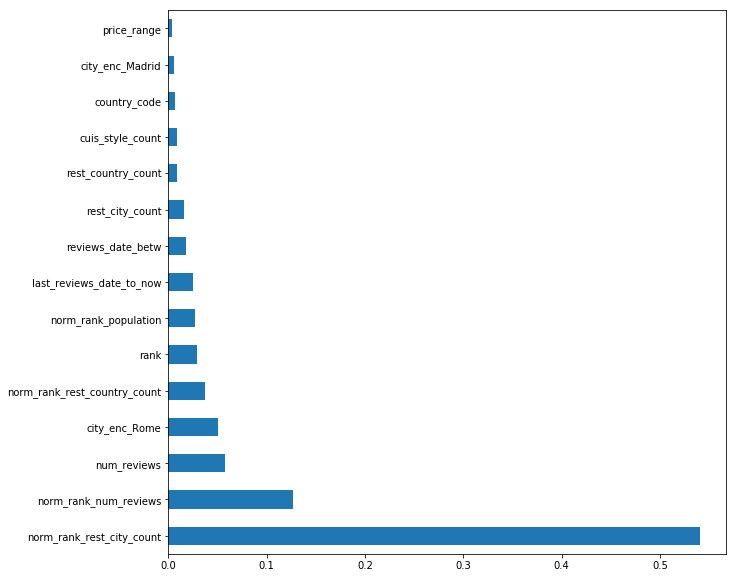

In [119]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [120]:
data.head(5)

,rank,price_range,num_reviews,sample,Rating,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,city_enc_Barcelona,...,cuis_other,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
0,12963.0,2,4.0,0,0.0,1,1,0,0,0,...,0,123.0,1543.0,0,7234,5,0.000547,0.986320,0.832796,51852.0
1,106.0,2,97.0,0,0.0,1,1,0,0,0,...,0,37.0,1336.0,0,475,4,-0.000714,-0.964698,-0.964698,10282.0
2,810.0,2,28.0,0,0.0,1,1,0,0,0,...,0,22.0,1313.0,0,7938,21,-0.000154,-0.100846,-0.009465,22680.0
3,1669.0,3,202.0,0,0.0,1,1,0,0,0,...,0,14.0,1335.0,0,7938,21,-0.000592,-0.903755,-0.818935,337138.0
4,37.0,3,162.0,0,0.0,1,1,0,0,0,...,0,15.0,1271.0,0,380,16,-0.000990,-1.119550,-1.119550,5994.0


# Submission
Если все устраевает - готовим Submission на кагл

In [121]:
test_data

,rank,price_range,num_reviews,Rating,capital,rest_chain,city_enc_Amsterdam,city_enc_Athens,city_enc_Barcelona,city_enc_Berlin,...,cuis_other,reviews_date_betw,last_reviews_date_to_now,id_ta_double,rest_country_count,country_code,norm_rank_population,norm_rank_rest_city_count,norm_rank_rest_country_count,norm_rank_num_reviews
0,12963.0,2,4.0,0.0,1,1,0,0,0,0,...,0,123.0,1543.0,0,7234,5,0.000547,0.986320,0.832796,51852.0
1,106.0,2,97.0,0.0,1,1,0,0,0,0,...,0,37.0,1336.0,0,475,4,-0.000714,-0.964698,-0.964698,10282.0
2,810.0,2,28.0,0.0,1,1,0,0,0,0,...,0,22.0,1313.0,0,7938,21,-0.000154,-0.100846,-0.009465,22680.0
3,1669.0,3,202.0,0.0,1,1,0,0,0,0,...,0,14.0,1335.0,0,7938,21,-0.000592,-0.903755,-0.818935,337138.0
4,37.0,3,162.0,0.0,1,1,0,0,0,0,...,0,15.0,1271.0,0,380,16,-0.000990,-1.119550,-1.119550,5994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4367.0,1,28.0,0.0,1,1,0,0,0,0,...,0,122.0,1327.0,0,7938,21,-0.000346,-0.528668,-0.479051,122276.0
9996,2612.0,2,2.0,0.0,1,0,0,0,0,0,...,0,0.0,1346.0,0,2289,15,0.001470,0.452137,0.325325,5224.0
9997,5562.0,2,2.0,0.0,0,0,0,0,0,0,...,0,123.0,1543.0,0,5283,10,0.001798,0.911645,0.464882,11124.0
9998,4010.0,2,2.0,0.0,0,0,0,0,0,0,...,0,123.0,1543.0,0,5283,10,0.000662,0.335550,0.171110,8020.0


In [122]:
test_data = test_data.drop(['Rating'], axis=1)

In [123]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [124]:
predict_submission = predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [125]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [126]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
